In [1]:
import numpy as np
import pandas as pd


In [2]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install neptune-client
!pip install mlxtend

  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)


Importing the dataset

In [3]:
dataset = pd.read_csv('Weather_AUS1.csv')

In [4]:
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
dataset.shape

(8425, 23)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8425 non-null   object 
 1   Location       8425 non-null   object 
 2   MinTemp        8350 non-null   float64
 3   MaxTemp        8365 non-null   float64
 4   Rainfall       8185 non-null   float64
 5   Evaporation    4913 non-null   float64
 6   Sunshine       4431 non-null   float64
 7   WindGustDir    7434 non-null   object 
 8   WindGustSpeed  7434 non-null   float64
 9   WindDir9am     7596 non-null   object 
 10  WindDir3pm     8117 non-null   object 
 11  WindSpeed9am   8349 non-null   float64
 12  WindSpeed3pm   8318 non-null   float64
 13  Humidity9am    8366 non-null   float64
 14  Humidity3pm    8323 non-null   float64
 15  Pressure9am    7116 non-null   float64
 16  Pressure3pm    7113 non-null   float64
 17  Cloud9am       6004 non-null   float64
 18  Cloud3pm

“RainToday” and “RainTomorrow” are objects (Yes / No). I will convert them to binary (1/0) for our convenience.

In [7]:
dataset['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
dataset['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

Next, we will check if the dataset is unbalanced or balanced. If the data set is unbalanced, we need to either downsample the majority or oversample the minority to balance it.

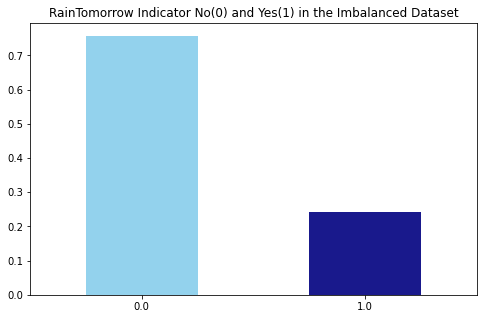

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
dataset.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

Handling Class Imbalance For Rainfall Prediction

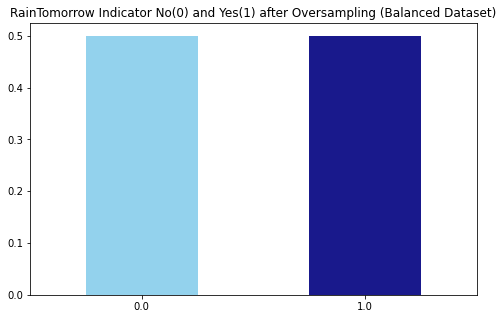

In [9]:
from sklearn.utils import resample

no = dataset[dataset.RainTomorrow == 0]
yes = dataset[dataset.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Now, I will now check the missing data model in the dataset:

<AxesSubplot:>

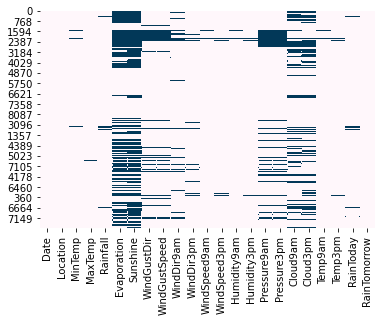

In [10]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

Obviously, “Evaporation”, “Sunshine”, “Cloud9am”, “Cloud3pm” are the features with a high missing percentage. So we will check the details of the missing data for these 4 features

In [11]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,5886,0.475061
Evaporation,5186,0.418563
Cloud9am,3202,0.258434
Cloud3pm,3197,0.258031


We observe that the 4 features have less than 50 per cent missing data. So instead of rejecting them completely, we’ll consider them in our model with proper imputation.

# Imputation and Transformation

In [12]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [13]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [14]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [15]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

Thus, the dataframe has no “NaN” value. We will now detect and eliminate outliers from the inter-quartile interval-based data set.

In [16]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1431.750000
Location            5.000000
MinTemp             8.300000
MaxTemp             8.400000
Rainfall            3.200000
Evaporation         4.238617
Sunshine            6.344000
WindGustDir         9.000000
WindGustSpeed      20.000000
WindDir9am          9.000000
WindDir3pm          7.000000
WindSpeed9am       13.000000
WindSpeed3pm       15.000000
Humidity9am        24.000000
Humidity3pm        27.123541
Pressure9am         8.200000
Pressure3pm         8.000000
Cloud9am            4.068659
Cloud3pm            4.000000
Temp9am             8.000000
Temp3pm             8.075000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [17]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(9748, 23)

<AxesSubplot:>

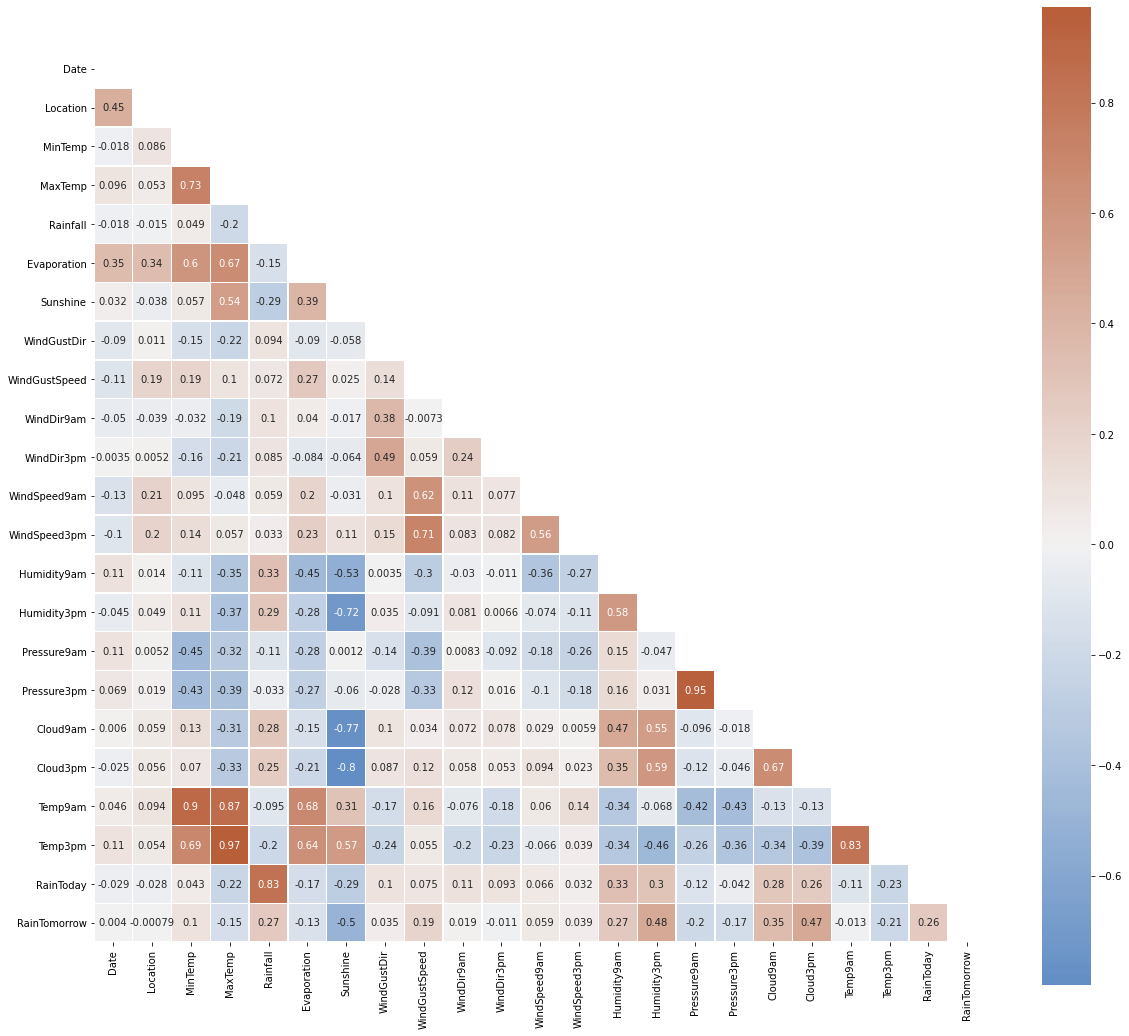

In [18]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

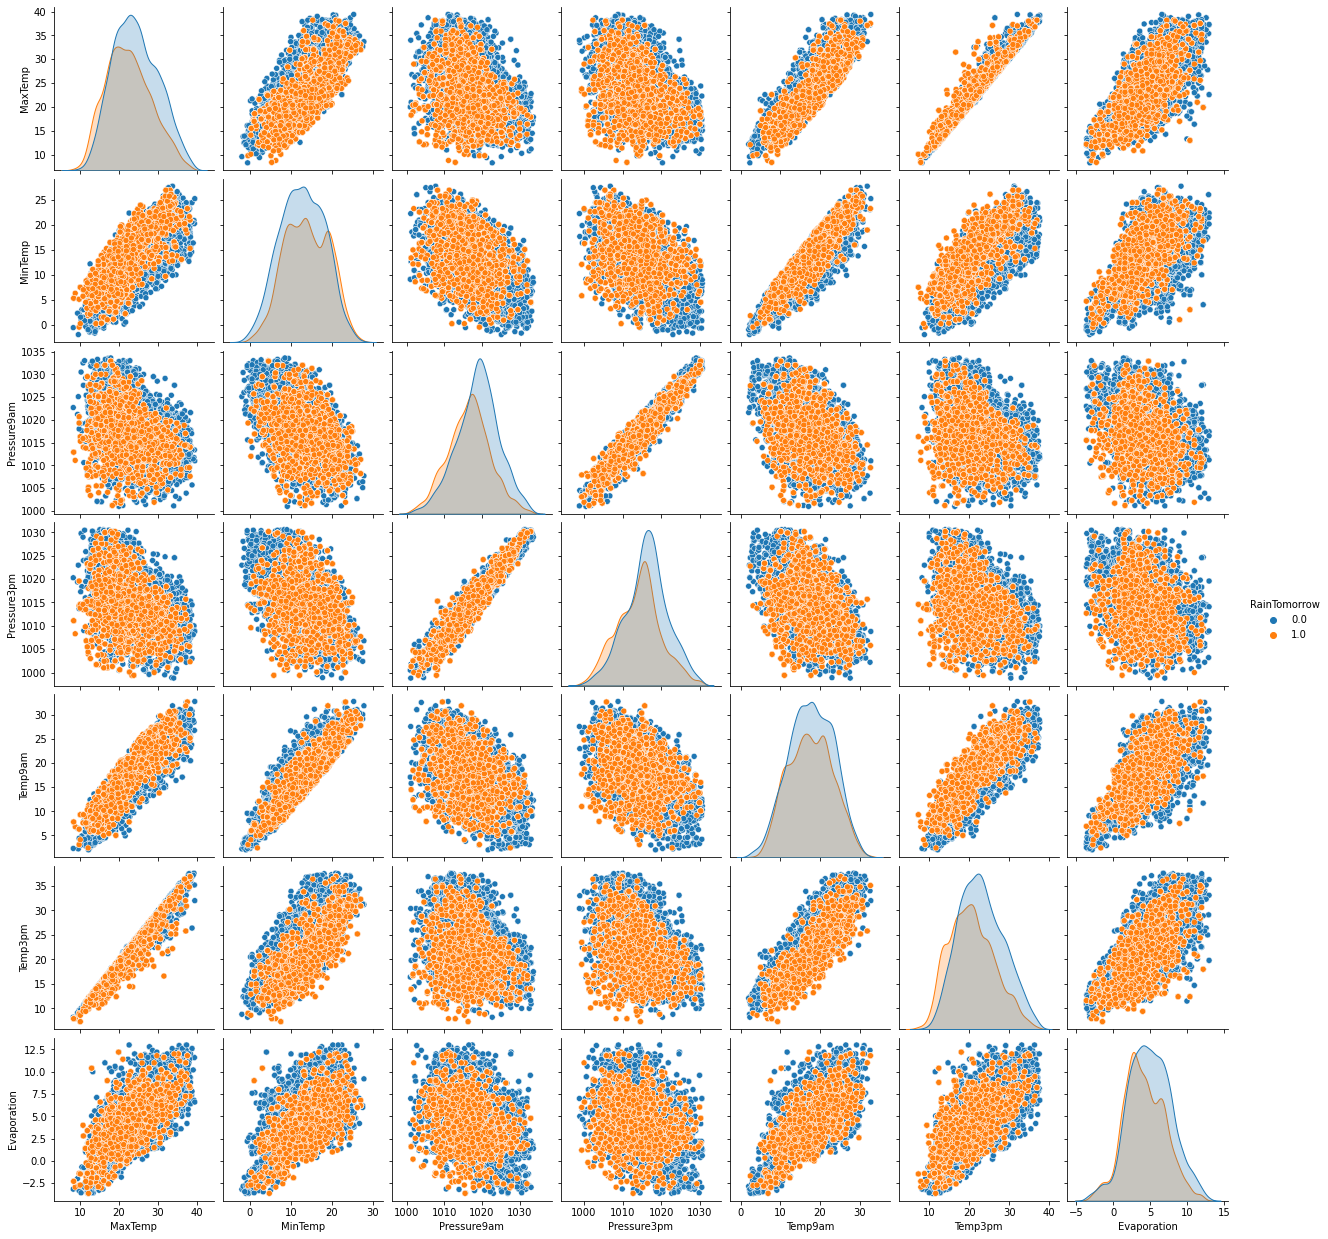

In [19]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

# Feature Selection for Rainfall Prediction

I will use both the filter method and the wrapper method for feature selection to train our rainfall prediction model.

Selecting features by filtering method (chi-square value): before doing this, we must first normalize our data. We use MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [20]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [21]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')


# Selection of features by wrapping method (random forest):

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Date', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm']
[0.04552285 0.02167373 0.03696247 0.03299921 0.02891997 0.0351255
 0.1177546  0.02179026 0.05071181 0.02497631 0.0259351  0.02587539
 0.02833827 0.04441683 0.11580411 0.04671925 0.05793059 0.04206377
 0.10439172 0.03533102 0.03867535 0.0180819 ]


# Training Rainfall Prediction Model with Different Models

We will divide the dataset into training (75%) and test (25%) sets respectively to train the rainfall prediction model. For best results, we will standardize our X_train and X_test data:

In [23]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [24]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [25]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7821091505949939
ROC Area under Curve = 0.7767197742925899
Cohen's Kappa = 0.5570463526967333
Time taken = 0.055997371673583984
              precision    recall  f1-score   support

         0.0    0.78491   0.83122   0.80740      1339
         1.0    0.77821   0.72222   0.74917      1098

    accuracy                        0.78211      2437
   macro avg    0.78156   0.77672   0.77829      2437
weighted avg    0.78189   0.78211   0.78117      2437



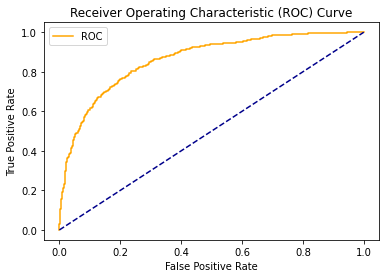

Accuracy = 0.8957734919983587
ROC Area under Curve = 0.8971209790086123
Cohen's Kappa = 0.7904842300795215
Time taken = 0.015994548797607422
              precision    recall  f1-score   support

         0.0    0.92350   0.88350   0.90305      1339
         1.0    0.86505   0.91075   0.88731      1098

    accuracy                        0.89577      2437
   macro avg    0.89427   0.89712   0.89518      2437
weighted avg    0.89716   0.89577   0.89596      2437



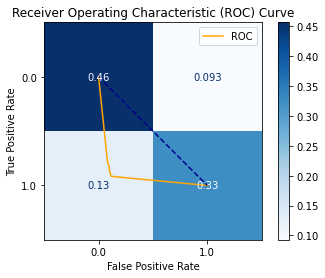

Accuracy = 0.9273697168649979
ROC Area under Curve = 0.9302176814113787
Cohen's Kappa = 0.8543434194037909
Time taken = 7.861567735671997
              precision    recall  f1-score   support

         0.0    0.96406   0.90142   0.93169      1339
         1.0    0.88861   0.95902   0.92247      1098

    accuracy                        0.92737      2437
   macro avg    0.92633   0.93022   0.92708      2437
weighted avg    0.93006   0.92737   0.92753      2437



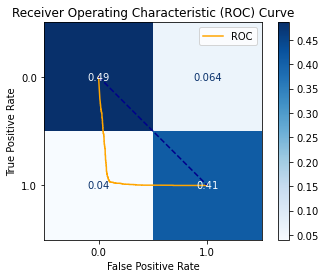

Accuracy = 0.9626590069757899
ROC Area under Curve = 0.9633966843102607
Cohen's Kappa = 0.9247469672892423
Time taken = 1.1673381328582764
              precision    recall  f1-score   support

         0.0    0.97561   0.95594   0.96567      1339
         1.0    0.94756   0.97086   0.95906      1098

    accuracy                        0.96266      2437
   macro avg    0.96158   0.96340   0.96237      2437
weighted avg    0.96297   0.96266   0.96270      2437



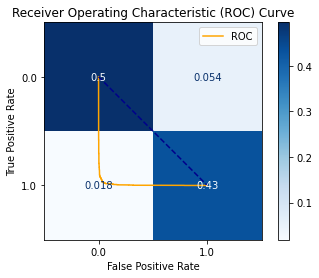

Accuracy = 0.9507591300779648
ROC Area under Curve = 0.9518300637590785
Cohen's Kappa = 0.9008544203590857
Time taken = 0.39010095596313477
              precision    recall  f1-score   support

         0.0    0.96849   0.94100   0.95455      1339
         1.0    0.93046   0.96266   0.94628      1098

    accuracy                        0.95076      2437
   macro avg    0.94947   0.95183   0.95042      2437
weighted avg    0.95135   0.95076   0.95082      2437



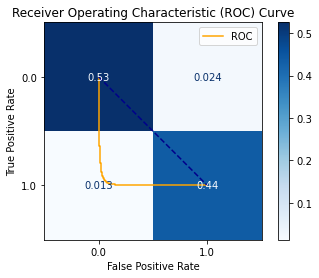

Accuracy = 0.9610176446450553
ROC Area under Curve = 0.961821071919751
Cohen's Kappa = 0.9214519889001718
Time taken = 69.55073523521423
              precision    recall  f1-score   support

         0.0    0.97481   0.95370   0.96414      1339
         1.0    0.94499   0.96995   0.95730      1098

    accuracy                        0.96102      2437
   macro avg    0.95990   0.96182   0.96072      2437
weighted avg    0.96137   0.96102   0.96106      2437



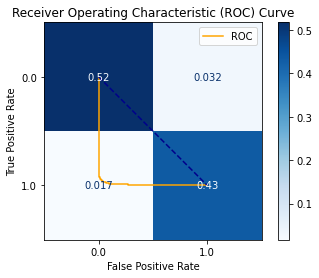

Accuracy = 0.9573245794009028
ROC Area under Curve = 0.9579685924982757
Cohen's Kappa = 0.9139895001544095
Time taken = 1.9306554794311523
              precision    recall  f1-score   support

         0.0    0.97030   0.95146   0.96078      1339
         1.0    0.94217   0.96448   0.95320      1098

    accuracy                        0.95732      2437
   macro avg    0.95623   0.95797   0.95699      2437
weighted avg    0.95762   0.95732   0.95737      2437



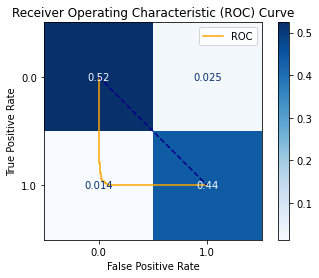

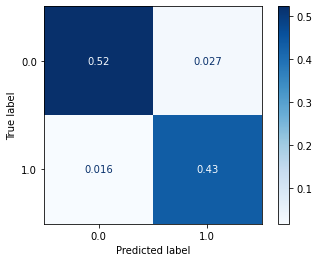

In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
!pip install catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

# Plotting Decision Region for all Models

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.


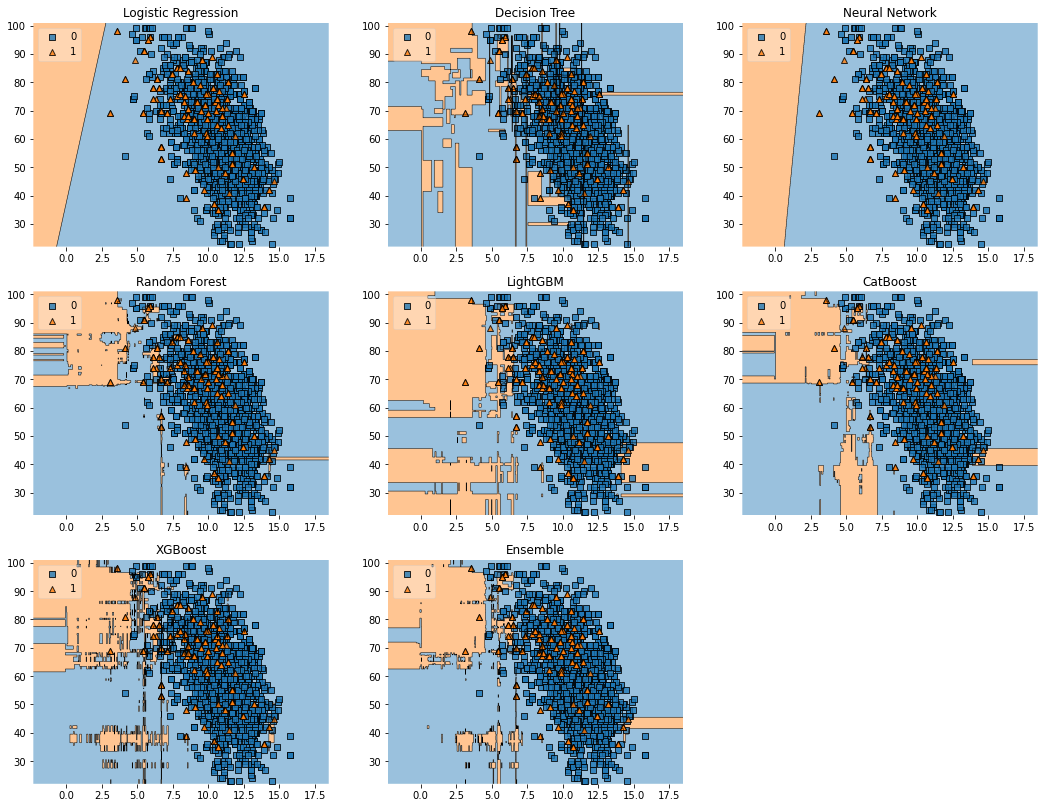

In [27]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()

# Rainfall Prediction Model Comparison

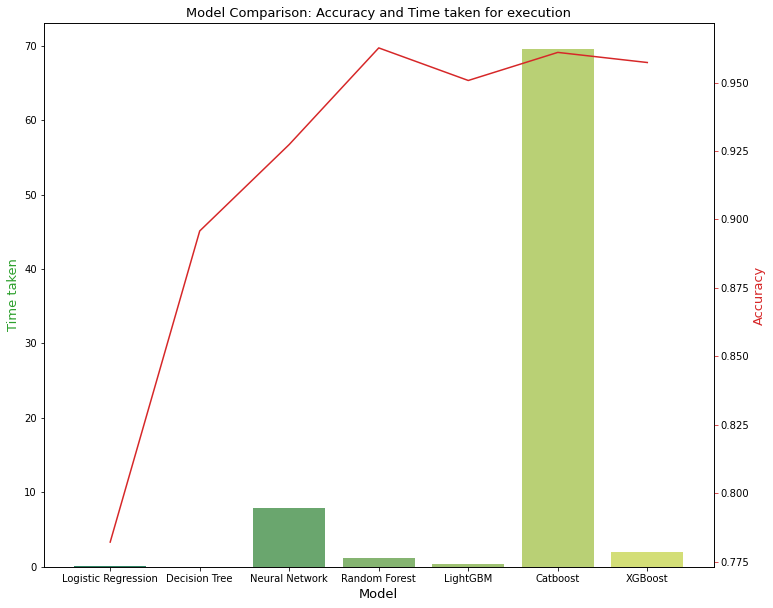

In [29]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_lgb, accuracy_cb, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_lgb, coh_kap_cb, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_lgb, tt_cb, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','LightGBM','Catboost','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

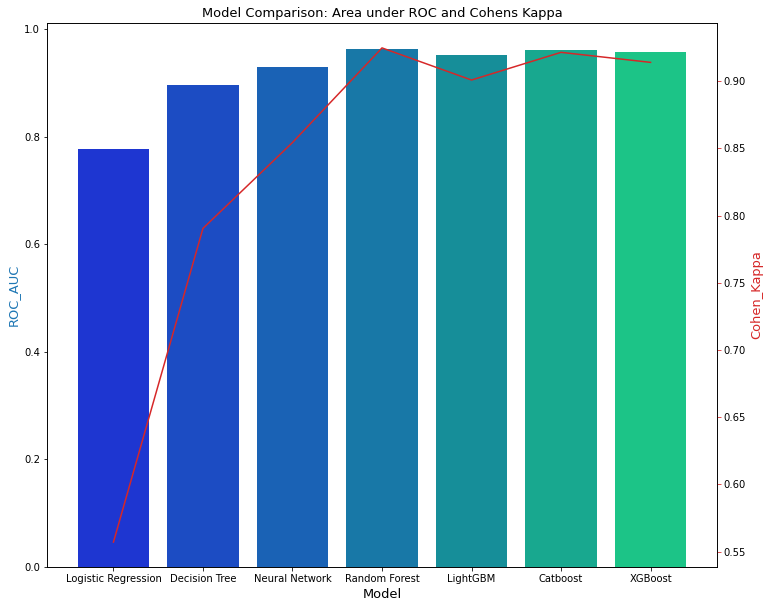

In [30]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

We can observe that XGBoost, CatBoost and Random Forest performed better compared to other models